In [23]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
def weight_variable_glorot(output_dim):
	input_dim = output_dim
	init_range = np.sqrt(6.0 / (input_dim + output_dim))
	initial = np.random.uniform(-init_range, init_range,
								(input_dim, output_dim))

	return initial

def pad_HR_adj(label, split):
	label = F.pad(label, (split, split, split, split), "constant", 0)
	label.fill_diagonal_(1)
	return label

def normalize_adj_torch(mx):
	rowsum = mx.sum(1)
	r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
	r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
	r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
	mx = torch.matmul(mx, r_mat_inv_sqrt)
	mx = torch.transpose(mx, 0, 1)
	mx = torch.matmul(mx, r_mat_inv_sqrt)
	return mx

def unpad(data, split):
	idx_0 = data.shape[0] - split
	idx_1 = data.shape[1] - split
	unpadded_data = data[split:idx_0, split:idx_1]
	return unpadded_data

In [26]:
class GraphUnpool(nn.Module):
    def __init__(self):
        super(GraphUnpool, self).__init__()

    def forward(self, A, X, idx):
        new_X = torch.zeros([A.shape[0], X.shape[1]]).to(device)
        new_X[idx] = X
        return A, new_X

class GraphPool(nn.Module):
    def __init__(self, k, in_dim):
        super(GraphPool, self).__init__()
        self.k = k
        self.proj = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, A, X):
        scores = self.proj(X)
        # scores = torch.abs(scores)
        scores = torch.squeeze(scores)
        scores = self.sigmoid(scores/100)
        num_nodes = A.shape[0]
        values, idx = torch.topk(scores, int(self.k*num_nodes))
        new_X = X[idx, :]
        values = torch.unsqueeze(values, -1)
        new_X = torch.mul(new_X, values)
        A = A[idx, :]
        A = A[:, idx]
        return A, new_X, idx


class GCN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(p=0)

    def forward(self, A, X):
        X = self.drop(X)
        X = torch.matmul(A, X)
        X = self.proj(X)
        return X

class GraphUnet(nn.Module):
    def __init__(self, ks, in_dim, out_dim, dim=320):
        super(GraphUnet, self).__init__()
        self.ks = ks

        self.start_gcn = GCN(in_dim, dim)
        self.bottom_gcn = GCN(dim, dim)
        self.end_gcn = GCN(2 * dim, out_dim)
        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim))
            self.up_gcns.append(GCN(dim, dim))
            self.pools.append(GraphPool(ks[i], dim))
            self.unpools.append(GraphUnpool())

    def forward(self, A, X):
        adj_ms = []
        indices_list = []
        down_outs = []
        X = self.start_gcn(A, X)
        start_gcn_outs = X
        org_X = X
        for i in range(self.l_n):

            X = self.down_gcns[i](A, X)
            adj_ms.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)
        X = self.bottom_gcn(A, X)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1

            A, idx = adj_ms[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, idx)
            X = self.up_gcns[i](A, X)
            X = X.add(down_outs[up_idx])
        X = torch.cat([X, org_X], 1)
        X = self.end_gcn(A, X)

        return X, start_gcn_outs

In [27]:
class GSRLayer(nn.Module):

	def __init__(self, hr_dim, device):
		super(GSRLayer, self).__init__()

		self.device = device
		self.weights = torch.from_numpy(
			weight_variable_glorot(hr_dim)).to(device=self.device, dtype=torch.float32)
		self.weights = torch.nn.Parameter(
			data=self.weights, requires_grad=True)

	def forward(self, A, X):
		with torch.autograd.set_detect_anomaly(True):

			lr = A
			lr_dim = lr.shape[0]
			f = X
			eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')

			# U_lr = torch.abs(U_lr)
			eye_mat = torch.eye(lr_dim).to(device=self.device, dtype=torch.float32)
			s_d = torch.cat((eye_mat, eye_mat), 0)

			a = torch.matmul(self.weights, s_d)
			b = torch.matmul(a, torch.t(U_lr))
			f_d = torch.matmul(b, f)
			f_d = torch.abs(f_d)
			f_d = f_d.fill_diagonal_(1)
			adj = f_d

			X = torch.mm(adj, adj.t())
			X = (X + X.t())/2
			X = X.fill_diagonal_(1)
		return adj, torch.abs(X)


class GraphConvolution(nn.Module):
	"""
	Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
	"""

	def __init__(self, in_features, out_features, dropout, act=F.relu):
		super(GraphConvolution, self).__init__()
		self.in_features = in_features
		self.out_features = out_features
		self.dropout = dropout
		self.act = act
		self.weight = torch.nn.Parameter(
			torch.FloatTensor(in_features, out_features))
		self.reset_parameters()

	def reset_parameters(self):
		torch.nn.init.xavier_uniform_(self.weight)

	def forward(self, input, adj):
		input = F.dropout(input, self.dropout, self.training)
		support = torch.mm(input, self.weight)
		output = torch.mm(adj, support)
		output = self.act(output)
		return output


In [28]:
class AGSRNet(nn.Module):

    def __init__(self, ks, args, device):
        super(AGSRNet, self).__init__()
        self.device = device

        self.lr_dim = args["lr_dim"]
        self.hr_dim = args["hr_dim"]
        self.hidden_dim = args["hidden_dim"]
        self.layer = GSRLayer(self.hr_dim, device)
        self.net = GraphUnet(ks, self.lr_dim, self.hr_dim)
        self.gc1 = GraphConvolution(
            self.hr_dim, self.hidden_dim, 0, act=F.relu)
        self.gc2 = GraphConvolution(
            self.hidden_dim, self.hr_dim, 0, act=F.relu)

    def forward(self, lr):
        with torch.autograd.set_detect_anomaly(True):
            I = torch.eye(self.lr_dim).to(device=self.device, dtype=torch.float32)
            A = normalize_adj_torch(lr).to(device=self.device, dtype=torch.float32)

            self.net_outs, self.start_gcn_outs = self.net(A, I)
            self.outputs, self.Z = self.layer(A, self.net_outs)

            self.hidden1 = self.gc1(self.Z, self.outputs)
            self.hidden2 = self.gc2(self.hidden1, self.outputs)
            z = self.hidden2

            z = (z + z.t())/2
            z = z.fill_diagonal_(1)

        return torch.abs(z), self.net_outs, self.start_gcn_outs, self.outputs


class Dense(nn.Module):
	def __init__(self, n1, n2, args):
		super(Dense, self).__init__()
		self.weights = torch.nn.Parameter(
			torch.FloatTensor(n1, n2).to(device), requires_grad=True)
		nn.init.normal_(self.weights, mean=args["mean_dense"], std=args["std_dense"])

	def forward(self, x):
		np.random.seed(1)
		torch.manual_seed(1)

		out = torch.mm(x, self.weights)
		return out


class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.dense_1 = Dense(args["hr_dim"], args["hr_dim"], args)
        self.relu_1 = nn.ReLU(inplace=False)
        self.dense_2 = Dense(args["hr_dim"], args["hr_dim"], args)
        self.relu_2 = nn.ReLU(inplace=False)
        self.dense_3 = Dense(args["hr_dim"], 1, args)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        np.random.seed(1)
        torch.manual_seed(1)
        dc_den1 = self.relu_1(self.dense_1(inputs))
        dc_den2 = self.relu_2(self.dense_2(dc_den1))
        output = dc_den2
        output = self.dense_3(dc_den2)
        output = self.sigmoid(output)
        return torch.abs(output)


def gaussian_noise_layer(input_layer, args):
    z = torch.empty_like(input_layer)
    noise = z.normal_(mean=args["mean_gaussian"], std=args["std_gaussian"])
    z = torch.abs(input_layer + noise)

    z = (z + z.t())/2
    z = z.fill_diagonal_(1)
    return z


In [29]:
criterion = nn.MSELoss()

def train(model, lr_train, hr_train, lr_val, hr_val, args):

	bce_loss = nn.BCELoss()
	netD = Discriminator(args)
	print(netD)
	optimizerG = optim.Adam(model.parameters(), lr=args["lr"])
	optimizerD = optim.Adam(netD.parameters(), lr=args["lr"])

	all_epochs_train_loss = []
	all_epochs_val_loss = []
	progress_bar = tqdm(range(args["epochs"]))
	for epoch in progress_bar:
		model.train()
		with torch.autograd.set_detect_anomaly(True):
			epoch_loss = []
			epoch_error = []
			for lr, hr in zip(lr_train, hr_train):
				optimizerD.zero_grad()
				optimizerG.zero_grad()

				hr = pad_HR_adj(hr, args["padding"])
				lr = lr.to(device=device, dtype=torch.float32)
				padded_hr = hr.to(device=device, dtype=torch.float32)

				eig_val_hr, U_hr = torch.linalg.eigh(padded_hr, UPLO='U')

				U_hr = U_hr.to(device)

				model_outputs, net_outs, start_gcn_outs, layer_outs = model(lr)

				mse_loss = args["lmbda"] * criterion(net_outs, start_gcn_outs) + criterion(
					model.layer.weights, U_hr) + criterion(model_outputs, padded_hr)

				error = criterion(model_outputs, padded_hr)
				real_data = model_outputs.detach()
				fake_data = gaussian_noise_layer(padded_hr, args)

				d_real = netD(real_data)
				d_fake = netD(fake_data)

				dc_loss_real = bce_loss(d_real, torch.ones(args["hr_dim"], 1).to(device))
				dc_loss_fake = bce_loss(d_fake, torch.zeros(args["hr_dim"], 1).to(device))
				dc_loss = dc_loss_real + dc_loss_fake

				dc_loss.backward()
				optimizerD.step()

				d_fake = netD(gaussian_noise_layer(padded_hr, args))

				gen_loss = bce_loss(d_fake, torch.ones(args["hr_dim"], 1).to(device))
				generator_loss = gen_loss + mse_loss
				generator_loss.backward()
				optimizerG.step()

				epoch_loss.append(generator_loss.item())
				epoch_error.append(error.item())

				progress_bar.set_description(f"Epoch loss {np.mean(epoch_loss)}, Epoch error {np.mean(epoch_error)*100}%")

			# print("Epoch: ", epoch, "Loss: ", np.mean(epoch_loss), "Error: ", np.mean(epoch_error)*100, "%")
			all_epochs_train_loss.append(np.mean(epoch_loss))

		model.eval()
		with torch.no_grad():
			epoch_val_loss = []
			epoch_val_error = []
			for lr, hr in zip(lr_val, hr_val):
				hr = pad_HR_adj(hr, args["padding"])
				lr = lr.to(device=device, dtype=torch.float32)
				padded_hr = hr.to(device=device, dtype=torch.float32)

				model_outputs, net_outs, start_gcn_outs, layer_outs = model(lr)

				mse_loss = args["lmbda"] * criterion(net_outs, start_gcn_outs) + criterion(
					model.layer.weights, U_hr) + criterion(model_outputs, padded_hr)

				error = criterion(model_outputs, padded_hr)
				epoch_val_loss.append(mse_loss.item())
				epoch_val_error.append(error.item())

			all_epochs_val_loss.append(np.mean(epoch_val_loss))
			# print("Validation Loss: ", np.mean(epoch_val_loss), "Validation Error: ", np.mean(epoch_val_error)*100, "%")
		progress_bar.set_postfix({"Loss": np.mean(all_epochs_train_loss), "Val Loss": np.mean(all_epochs_val_loss)})

def test(model, test_adj, test_labels, args):

	g_t = []
	test_error = []
	preds_list = []

	# i = 0

	for lr, hr in zip(test_adj, test_labels):
		all_zeros_lr = not np.any(lr)
		all_zeros_hr = not np.any(hr)
		if all_zeros_lr == False and all_zeros_hr == False:
			lr = lr.type(torch.FloatTensor)
			hr.fill_diagonal_(1)
			hr = pad_HR_adj(hr, args["padding"])
			hr = hr.type(torch.FloatTensor)
			preds, a, b, c = model(lr)

			preds_list.append(preds.flatten().detach().numpy())
			error = criterion(preds, hr)
			g_t.append(hr.flatten())
			print(error.item())
			test_error.append(error.item())
			# i += 1

	print("Test error MSE: ", np.mean(test_error))


In [30]:
args = {
    "epochs": 100,
	"lr": 0.0001,
	"lmbda": 0.01,
	"lr_dim": 160,
	"hr_dim": 320,
	"hidden_dim": 320,
    "padding": 26,
	"mean_dense": 0,
	"std_dense": 0.01,
	"mean_gaussian": 0,
	"std_gaussian": 0.01
}
ks = [0.9, 0.7, 0.6, 0.5]

model = AGSRNet(ks, args, device).to(device)
discriminator = Discriminator(args).to(device)

In [34]:
# load data "data/lr_train.pt"
lr_train = torch.load("data/lr_train.pt")
hr_train = torch.load("data/hr_train.pt")
lr_test = torch.load("data/lr_test.pt")

In [35]:
from utils.matrix_vectorizer import MatrixVectorizer
mv = MatrixVectorizer()

lr_train = torch.stack([mv.anti_vectorize(lr_train[i], 160) for i in range(len(lr_train))]).to(device)
hr_train = torch.stack([mv.anti_vectorize(hr_train[i], 268) for i in range(len(hr_train))]).to(device)

In [36]:
from sklearn.model_selection import train_test_split
lr_train, lr_val, hr_train, hr_val = train_test_split(lr_train, hr_train, test_size=0.2, random_state=42)

print("Training samples: ", len(lr_train))
print("Validation samples: ", len(lr_val))

Training samples:  133
Validation samples:  34


In [ ]:
train(model, lr_train, hr_train, lr_val, hr_val, args)

Discriminator(
  (dense_1): Dense()
  (relu_1): ReLU()
  (dense_2): Dense()
  (relu_2): ReLU()
  (dense_3): Dense()
  (sigmoid): Sigmoid()
)


Epoch loss 3.071860072192024, Epoch error 5.000955173197914%:   1%|          | 1/100 [01:17<1:15:49, 45.95s/it, Loss=2.98, Val Loss=0.0572]  

torch.Size([268, 268])


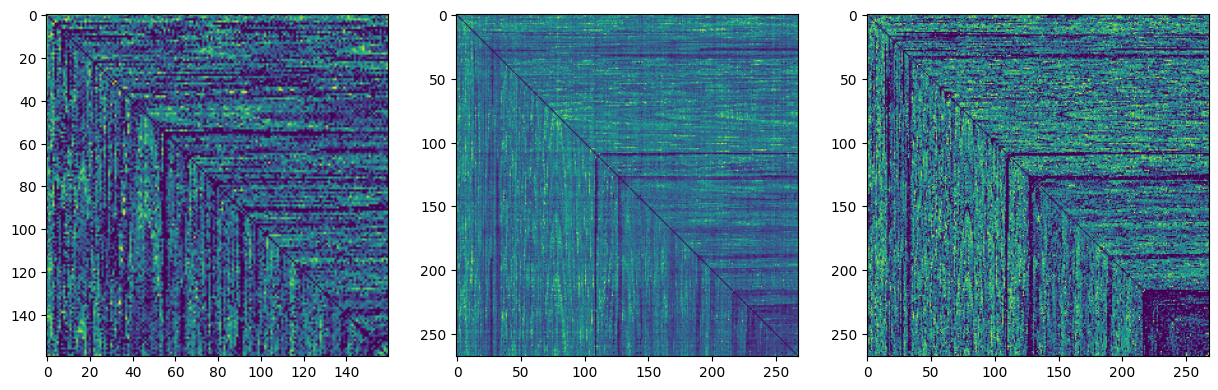

In [22]:
# show input, output and target
k = 30
input = lr_train[k]
output = unpad(model(input)[0], 26)
print(output.shape)

target = hr_train[k]

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input.cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow(output.cpu().detach().numpy() - np.eye(268))
plt.subplot(1, 3, 3)
plt.imshow(target.cpu().detach().numpy())

plt.show()

In [22]:
torch.save(model, "model-asgr.pt")

In [13]:
model = torch.load("model-asgr.pt", weights_only=False)